这节课开始，进入到NLP的领域，首先我们来看看，序列模型到底是啥

其实序列模型是有了解过的，比如说我们熟悉的HMM模型，这东西就是个序列模型

* 序列模型的一个基本假设是，实际应用场景里面的很多数据都是具有时序信息的
* 这个东西其实在实际的生物信息学应用里面，也是真实存在的
* 时序数据的本质，就是一连串的不独立的随机变量观测，服从一个分布p(X)，实际上所有的机器学习问题也都是在尽量去拟合这个真实的p(X)
* 从单纯的条件概率来说，其实一个序列随机变量是可以正着算也可以反着算的，但是反着算在实际物理学上很多时候可能是不显示的（你时间总不能反着来）
* 不过RNN模型是正着反着都可以的

什么东西是自回归模型呢？
* 自回归模型其实就是最最简单的针对序列数据的预测
* 假设我们有0-t时刻的数据，这是我们的训练集，我们想要针对这个训练集去训练模型参数，然后预测下一时刻也就是t+1时刻的数据是什么样子的
* 以往我们在分类模型或者是回归模型中，我们的训练数据和预测的结果往往是不一样的（比如用图片预测label，或者用一些数据去预测房价）
* 但是在序列模型中，我们的训练数据其实和预测的结果本质上是一个东西，只是在不同的时间位置上，这也就是为什么被叫做自回归模型

想要解决自回归预测问题，目前提出了几个假设
* 第一个就是马尔可夫性假设，当前时间下的状态只跟过去有限的时间上的状态相关
* 第二个是潜变量假设，这个其实和隐变量的思想非常像，我们前面可以用复杂的条件概率函数来表示任何时间的状态，那我们把条件概率中的条件直接改成一个变量ht，这样就可以简化表示了

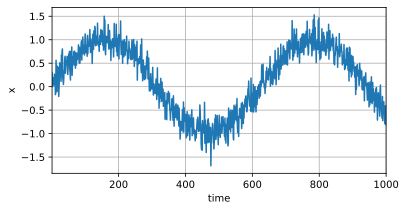

In [1]:
# 接下来我们看一个简单的例子，引入马尔可夫假设后，如何用MLP来训练一个带有时序信息的数据
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
# 这里我们设置的马尔可夫的阶数是4
# 可以发现这里其实每个x，都是跟前面四个时间点的相关的
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [3]:
# 就是个MLP
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [4]:
# 训练
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.053942
epoch 2, loss: 0.051168
epoch 3, loss: 0.050775
epoch 4, loss: 0.054351
epoch 5, loss: 0.049695


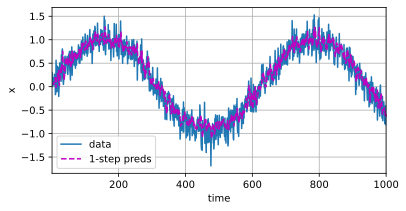

In [5]:
# 这里我们来做一个单步预测，也就是给一个x，预测下一个阶段
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

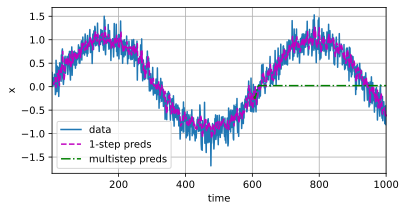

In [6]:
# 但是如果用多步预测，会发现是一坨狗屎
# 这里和上面的区别是，多步预测其实是我们在不断用预测的数据当作真实数据去再次预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))


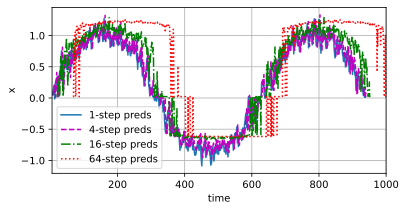

In [7]:
# 不同step，也就是给你一定数据，预测往后n个点的数据，预测完，再给你真实数据
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

所以实际上可以发现，单步预测或者是比较近的未来的预测是容易的，因为我们给你的真实数据是足够接近预测目标的
* 但是发现多步预测的话，最严重的问题就是我们在不断用存在bias的数据去预测新的数据，形成恶性循环
* 这也是我们之后的模型要解决的问题